In [2]:
!pip -qqq install openai
!pip -qqq install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.8 MB/s eta 0:00:00


**Load Data**

In [26]:
import pandas as pd

def txt_to_dataframe(input_file, encoding='utf-8'):
    data = []
    with open(input_file, 'r', encoding=encoding, errors='ignore') as txt_file:
        for line in txt_file:
            text, sentiment = line.rsplit('@', 1)
            data.append([text.strip(), sentiment.strip()])

    df = pd.DataFrame(data, columns=['Text', 'Sentiment'])
    return df

df1 = txt_to_dataframe('Sentences_AllAgree.txt', encoding='latin1')
df2 = txt_to_dataframe('Sentences_75Agree.txt', encoding='latin1')


# Display the dataframes
print("Sentences_AllAgree:")
print(df1.head())
print("\nSentences_75Agree:")
print(df2.head())


Sentences_AllAgree:
                                                Text Sentiment
0  According to Gran , the company has no plans t...   neutral
1  For the last quarter of 2010 , Componenta 's n...  positive
2  In the third quarter of 2010 , net sales incre...  positive
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive
4  Operating profit totalled EUR 21.1 mn , up fro...  positive

Sentences_75Agree:
                                                Text Sentiment
0  According to Gran , the company has no plans t...   neutral
1  With the new production plant the company woul...  positive
2  For the last quarter of 2010 , Componenta 's n...  positive
3  In the third quarter of 2010 , net sales incre...  positive
4  Operating profit rose to EUR 13.1 mn from EUR ...  positive


**Zero - Shot - Prompting**

In [20]:
import openai
from google.colab import userdata

client = openai.OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

# Sample 60 examples equally distributed among neutral, positive, and negative sentiments
def sample_data(df, sample_size=60):
    df_neutral = df[df['Sentiment'] == 'neutral'].sample(n=sample_size // 3)
    df_positive = df[df['Sentiment'] == 'positive'].sample(n=sample_size // 3)
    df_negative = df[df['Sentiment'] == 'negative'].sample(n=sample_size // 3)
    return pd.concat([df_neutral, df_positive, df_negative]).sample(frac=1).reset_index(drop=True)

sampled_df = sample_data(df1)

# Function to get sentiment using GPT-3.5
def get_sentiment(text):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful retail investor assistant that determines the sentiment of financial news headlines from the perspective of a retail investor as positive, neutral, or negative."},
            {"role": "user", "content": f"Determine the sentiment of the following financial news headline from the perspective of a retail investor as positive, neutral, or negative and only give me one word answer:\n\n{text}"}
        ],
        max_tokens=1,
        temperature=0.0
    )
    sentiment = response.choices[0].message.content.strip().lower()
    return sentiment

# Apply the function to the sampled DataFrame
sampled_df['Predicted_Sentiment'] = sampled_df['Text'].apply(get_sentiment)

# Calculate accuracy
accuracy = (sampled_df['Sentiment'].str.lower() == sampled_df['Predicted_Sentiment']).mean()

print(f"Baseline Accuracy: {accuracy * 100:.2f}%")

# Display the DataFrame with predictions
sampled_df.head()

Baseline Accuracy: 86.67%


,Text,Sentiment,Predicted_Sentiment
0,Mr Jortikka is president of the base metal div...,neutral,neutral
1,"Operating loss totalled EUR 12.7 mn , compared...",negative,negative
2,The record date for dividend distribution is M...,neutral,neutral
3,"In Q2 of 2009 , profit before taxes amounted t...",negative,negative
4,Glaston 's net profit for the third quarter of...,negative,negative


**12 - Shot - Prompting**

In [25]:
# Prepare the 12-shot prompt
def create_few_shot_prompt(df, num_examples=4):
    examples = []
    for sentiment in ['positive', 'neutral', 'negative']:
        examples += df[df['Sentiment'] == sentiment].sample(n=num_examples).apply(
            lambda row: f"Text: {row['Text']}\nSentiment: {row['Sentiment']}\n", axis=1).tolist()
    return "\n".join(examples)

few_shot_prompt = create_few_shot_prompt(df1)

# Function to get sentiment using 12-shot GPT-3.5 prompt
def get_few_shot_sentiment(text, few_shot_prompt):
    prompt = (
        f"You are a helpful retail investor assistant that determines the sentiment of financial news headlines from the perspective of a retail investor as positive, neutral, or negative.\n\n"
        f"Here are some examples:\n"
        f"{few_shot_prompt}\n"
        f"Determine the sentiment of the following financial news headline from the perspective of a retail investor as positive, neutral, or negative and only give me one word answer:\n\n"
        f"Text: {text}\nSentiment:"
    )
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful retail investor assistant that determines the sentiment of financial news headlines from the perspective of a retail investor as positive, neutral, or negative."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=10,
        temperature=0.0
    )
    sentiment = response.choices[0].message.content.strip().lower()
    return sentiment

# Apply the function to the sampled DataFrame
sampled_df['Few_Shot_Predicted_Sentiment'] = sampled_df['Text'].apply(lambda text: get_few_shot_sentiment(text, few_shot_prompt))

# Calculate accuracy for 12-shot prompting
few_shot_accuracy = (sampled_df['Sentiment'].str.lower() == sampled_df['Few_Shot_Predicted_Sentiment']).mean()

print(f"12-Shot Prompting Accuracy: {few_shot_accuracy * 100:.2f}%")

# Display the DataFrame with predictions
sampled_df.head()


12-Shot Prompting Accuracy: 88.33%


,Text,Sentiment,Predicted_Sentiment,Few_Shot_Predicted_Sentiment
0,Mr Jortikka is president of the base metal div...,neutral,neutral,neutral
1,"Operating loss totalled EUR 12.7 mn , compared...",negative,negative,negative
2,The record date for dividend distribution is M...,neutral,neutral,positive
3,"In Q2 of 2009 , profit before taxes amounted t...",negative,negative,negative
4,Glaston 's net profit for the third quarter of...,negative,negative,negative


**Fine - Tuning**

In [4]:
import json
import pandas as pd

# Combine the datasets
combined_df = pd.concat([df1, df2]).reset_index(drop=True)

# Sample 150 items for each sentiment for training
def sample_sentiment_data(df, num_samples=150):
    samples = []
    for sentiment in ['positive', 'neutral', 'negative']:
        samples.append(df[df['Sentiment'] == sentiment].sample(n=num_samples, random_state=42))
    return pd.concat(samples)

train_df = sample_sentiment_data(combined_df)

# Remove training samples from the combined dataset for testing
test_df = combined_df.drop(train_df.index).sample(n=500, random_state=42).reset_index(drop=True)

# Convert the fine-tuning data to JSONL format
jsonl_file_path = 'fine_tuning_data.jsonl'

with open(jsonl_file_path, 'w') as jsonl_file:
    for _, row in train_df.iterrows():
        record = {
            "messages": [
                {"role": "system", "content": "You are a helpful assistant that determines the sentiment of a given text as positive, neutral, or negative."},
                {"role": "user", "content": str(row['Text'])},
                {"role": "assistant", "content": str(row['Sentiment'])}
            ]
        }
        jsonl_file.write(json.dumps(record) + '\n')

print(f"Fine-tuning data has been saved as {jsonl_file_path}")


Fine-tuning data has been saved as fine_tuning_data.jsonl


In [24]:
print(f"Training Data Shape: {train_df.shape}")
print(f"Testing Data Shape: {test_df.shape}")

Training Data Shape: (450, 2)
Testing Data Shape: (500, 2)


In [32]:
# Upload the file for fine-tuning
with open(jsonl_file_path, 'rb') as file:
    result = client.files.create(
        file=file,
        purpose='fine-tune'
    )

# Get the file ID
file_id = result.id
print(f"File ID: {file_id}")

# Create fine-tuning job
fine_tune_response = client.fine_tuning.jobs.create(
    training_file=file_id,
    model="gpt-3.5-turbo"
)

# Print fine-tune job details
print(f"Fine-tuning job: {fine_tune_response.id}")


File ID: file-QAo2qMumnWhmznJ1SIDrEHzT
Fine-tuning job: ftjob-Sykep7TmsdF1MtxQmyuermD5


**Prediction**

In [10]:
import openai

# Function to get sentiment using the fine-tuned model
def get_fine_tuned_sentiment(text, model_name):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that determines the sentiment of a given text as positive, neutral, or negative."},
            {"role": "user", "content": f"Determine the sentiment of the following financial news headline from the perspective of a retail investor as positive, neutral, or negative and only give me one word answer:\n\nText: {text}\nSentiment:"}
        ],
        max_tokens=10,
        temperature=0.0
    )
    sentiment = response.choices[0].message.content.strip().lower()
    return sentiment

# Use the fine-tuned model to predict sentiment
model_name = "ft:gpt-3.5-turbo-0125:personal::9h4rm99N"
test_df['Predicted_Sentiment'] = test_df['Text'].apply(lambda text: get_fine_tuned_sentiment(text, model_name))

# Calculate accuracy
fine_tuned_accuracy = (test_df['Sentiment'].str.lower() == test_df['Predicted_Sentiment']).mean()

print(f"Fine-Tuned Model Accuracy: {fine_tuned_accuracy * 100:.2f}%")

# Display the DataFrame with predictions
test_df.head()


Fine-Tuned Model Accuracy: 93.40%


,Text,Sentiment,Predicted_Sentiment
0,`` We have the most expensive water brand in F...,neutral,negative
1,The beers differ slightly from mainstream beers .,neutral,neutral
2,"Trading in the new shares , which have right t...",neutral,neutral
3,`` Our Vaalipalvelu-service was especially dev...,neutral,neutral
4,Affecto expects its net sales for the whole 20...,positive,positive


**Confusion Matrix : Sentiment vs Predicted_Sentiment**

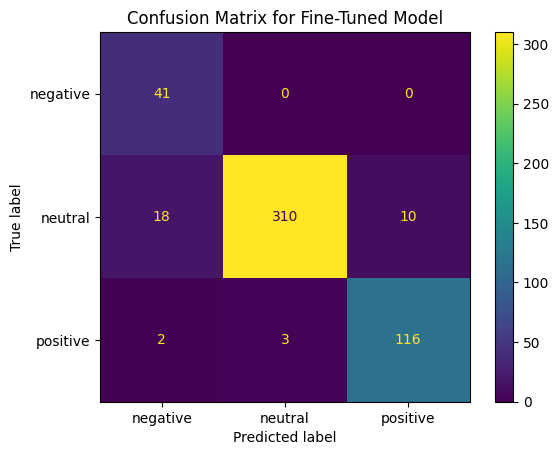

In [13]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_df['Sentiment'].str.lower(), test_df['Predicted_Sentiment'])

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['negative', 'neutral', 'positive'])
cm_display.plot()
plt.title('Confusion Matrix for Fine-Tuned Model')
plt.show()


**Human - Level - Accuracy - Check**

I have gathered 10 financial news headlines from different websites and assigned them sentiment values. I will now compare my assessments with the predictions from the fine-tuned model. Please note that my assessments may not be entirely accurate, as I am not an expert in this field.

In [18]:
import openai
import pandas as pd

# List of news items
news_items = [
    "Reliance Jio and Airtel have hiked their prices starting today. This change affects various service plans and is aimed at increasing revenue amidst growing competition.",
    "Paytm has introduced the 'Health Saathi Plan' for just ₹35 per month, offering several health benefits to its users. This initiative aims to make health services more accessible.",
    "Lighthouse Funds is reportedly in early talks to sell its stake in the footwear company Aqualite, which may indicate strategic changes or expansions for both entities.",
    "Nvidia chips are being smuggled into China through an underground network, highlighting the ongoing tech tensions and supply chain challenges between the US and China.",
    "Boeing is expected to see a slowdown in Max aircraft deliveries. This may impact airlines like Akasa and AI Express, which rely on these models for their fleet expansion.",
    "Apple is poised to gain an observer role on OpenAI's board as part of a new AI pact, underscoring its growing interest and investments in artificial intelligence technologies.",
    "Tempur Sealy's acquisition of Mattress Firm is under scrutiny as the FTC plans to sue to block the deal, citing potential anti-competitive concerns in the mattress market.",
    "Unacademy has laid off 250 employees amidst rumors of a potential merger, indicating significant restructuring within the company.",
    "Suryoday Small Finance Bank reported a 42% jump in gross advances in Q1, reflecting strong growth and increased lending activities.",
    "Tesla's stock has surged nearly 25% this week, with analysts raising their price targets as the company approaches its highest share price of the year."
]

# List of manual sentiments
manual_sentiments = [
    "negative",
    "positive",
    "neutral",
    "negative",
    "negative",
    "neutral",
    "positive",
    "negative",
    "positive",
    "positive"
]

# get sentiment using the fine-tuned model
model_name = "ft:gpt-3.5-turbo-0125:personal::9h4rm99N"
predicted_sentiments = [get_fine_tuned_sentiment(item, model_name) for item in news_items]

# Calculate human-level accuracy
correct_predictions = sum(1 for predicted, manual in zip(predicted_sentiments, manual_sentiments) if predicted == manual)
total_items = len(news_items)
human_accuracy = correct_predictions / total_items

print(f"Human-Level Accuracy: {human_accuracy * 100:.2f}%")

# Display results
for i, (item, predicted, manual) in enumerate(zip(news_items, predicted_sentiments, manual_sentiments)):
    print(f"News Item {i+1}: {item}")
    print(f"Predicted Sentiment: {predicted}")
    print(f"Manual Sentiment: {manual}")
    print(f"Correct: {predicted == manual}")
    print()


Human-Level Accuracy: 80.00%
News Item 1: Reliance Jio and Airtel have hiked their prices starting today. This change affects various service plans and is aimed at increasing revenue amidst growing competition.
Predicted Sentiment: negative
Manual Sentiment: negative
Correct: True

News Item 2: Paytm has introduced the 'Health Saathi Plan' for just ₹35 per month, offering several health benefits to its users. This initiative aims to make health services more accessible.
Predicted Sentiment: positive
Manual Sentiment: positive
Correct: True

News Item 3: Lighthouse Funds is reportedly in early talks to sell its stake in the footwear company Aqualite, which may indicate strategic changes or expansions for both entities.
Predicted Sentiment: neutral
Manual Sentiment: neutral
Correct: True

News Item 4: Nvidia chips are being smuggled into China through an underground network, highlighting the ongoing tech tensions and supply chain challenges between the US and China.
Predicted Sentiment: 